In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import datetime as dt

In [2]:
from vacances_scolaires_france import SchoolHolidayDates
from jours_feries_france.compute import JoursFeries

In [3]:
import matplotlib
import matplotlib.pyplot as plt

In [4]:
dt.date(2018, 1, 1) in JoursFeries.for_year(2018).values()

True

In [5]:
d = SchoolHolidayDates()

In [6]:
train = pd.read_csv("./GBS_Building_Attendance-Train.csv")
meeting = pd.read_csv("./GBS_Building_Attendance-Meeting_Room.csv")

In [7]:
meeting.head()

,building_floor,meeting_room_capacity,meeting_room_number
0,T103,92.0,5
1,T104,78.0,10
2,T105,67.0,10
3,T106,88.0,11
4,T107,68.0,10


In [8]:
train.head(1)

,date_hour,building_floor,number_of_metro_1,number_of_rer_a,temp_c,high_cloud_cover_per,medium_cloud_cover_per,low_cloud_cover_per,precipitation_mm,sunshine_duration_h,is_a_strike_ratp_day,is_a_strike_sncf_day,floor_capacity,attendance
0,2019-04-12 00:00:00,T100,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,NO,NO,266.0,0.0


In [9]:
train['date_hour'] = train.date_hour.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
train['Date'] = train.date_hour.apply(lambda dt: dt.year*10000 + dt.month* 100  + dt.day)
train['Hour'] = train.date_hour.apply(lambda x: x.time().hour)
train['Weekday'] = train.date_hour.apply(lambda x: x.weekday())
train['Floor'] = train.building_floor.apply(lambda x: int(x[2:]))
train['isWeekend'] = train.Weekday.apply(lambda x: 1 if x in (5,6) else 0)

In [10]:
train['isHoliday'] = train.date_hour.apply(lambda x: d.is_holiday_for_zone(dt.date(x.year, x.month, x.day), 'C'))
train['isPublicHoliday'] = train.date_hour.apply(lambda x: dt.date(x.year, x.month, x.day) in JoursFeries.for_year(x.year).values())

In [11]:
train.head()

,date_hour,building_floor,number_of_metro_1,number_of_rer_a,temp_c,high_cloud_cover_per,medium_cloud_cover_per,low_cloud_cover_per,precipitation_mm,sunshine_duration_h,...,is_a_strike_sncf_day,floor_capacity,attendance,Date,Hour,Weekday,Floor,isWeekend,isHoliday,isPublicHoliday
0,2019-04-12,T100,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,NO,266.0,0.0,20190412,0,4,0,0,False,False
1,2019-04-12,T101,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,NO,178.0,0.0,20190412,0,4,1,0,False,False
2,2019-04-12,T102,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,NO,306.0,0.0,20190412,0,4,2,0,False,False
3,2019-04-12,T103,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,NO,173.0,7.0,20190412,0,4,3,0,False,False
4,2019-04-12,T104,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,NO,221.0,74.0,20190412,0,4,4,0,False,False


In [12]:
traffic = pd.read_csv("traffic.csv", delimiter = ";")

In [13]:
traffic.Hour = traffic.Hour.apply(lambda x: dt.datetime.strptime(x, '%I:%M %p').time().hour)

In [14]:
traffic.Traffic = traffic.Traffic.apply(lambda x: x.rstrip('%'))

In [15]:
traffic['isTraffic'] = traffic.Traffic.apply(lambda x: 1 if int(x) > 50 else 0)
traffic = traffic.drop(['Traffic'], axis = 1)

In [16]:
#train = train.merge(traffic, on = ["Weekday", "Hour"])

In [17]:
train = train.fillna(0)

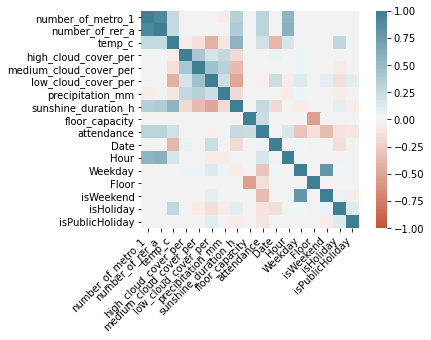

In [18]:
import seaborn as sns

corr = train.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [19]:
corr.attendance

number_of_metro_1         0.313920
number_of_rer_a           0.317083
temp_c                    0.205551
high_cloud_cover_per     -0.005315
medium_cloud_cover_per   -0.012687
low_cloud_cover_per      -0.039771
precipitation_mm         -0.032349
sunshine_duration_h       0.263262
floor_capacity            0.234531
attendance                1.000000
Date                      0.023607
Hour                      0.168674
Weekday                  -0.306603
Floor                    -0.123205
isWeekend                -0.353690
isHoliday                -0.110182
isPublicHoliday          -0.094258
Name: attendance, dtype: float64

In [20]:
# DayPeriod: 
# 1 = working
# 2 = lunch
# 3 = out of office

In [21]:
train['DayPeriod'] = train.Hour.apply(lambda x: 1 if x in (9,10, 11, 15, 16, 17, 18, 19) else 2 if x in (12, 13, 14) else 3 )

In [22]:
train = train.replace("NO", 0).replace("YES", 1).replace('True', 1).replace('False', 0)

In [23]:
train.head()

,date_hour,building_floor,number_of_metro_1,number_of_rer_a,temp_c,high_cloud_cover_per,medium_cloud_cover_per,low_cloud_cover_per,precipitation_mm,sunshine_duration_h,...,floor_capacity,attendance,Date,Hour,Weekday,Floor,isWeekend,isHoliday,isPublicHoliday,DayPeriod
0,2019-04-12,T100,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,266.0,0.0,20190412,0,4,0,0,False,False,3
1,2019-04-12,T101,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,178.0,0.0,20190412,0,4,1,0,False,False,3
2,2019-04-12,T102,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,306.0,0.0,20190412,0,4,2,0,False,False,3
3,2019-04-12,T103,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,173.0,7.0,20190412,0,4,3,0,False,False,3
4,2019-04-12,T104,32.0,26.0,6.0,0.0,0.0,0.0,0.0,0.0,...,221.0,74.0,20190412,0,4,4,0,False,False,3


In [24]:
train.columns

Index(['date_hour', 'building_floor', 'number_of_metro_1', 'number_of_rer_a',
       'temp_c', 'high_cloud_cover_per', 'medium_cloud_cover_per',
       'low_cloud_cover_per', 'precipitation_mm', 'sunshine_duration_h',
       'is_a_strike_ratp_day', 'is_a_strike_sncf_day', 'floor_capacity',
       'attendance', 'Date', 'Hour', 'Weekday', 'Floor', 'isWeekend',
       'isHoliday', 'isPublicHoliday', 'DayPeriod'],
      dtype='object')

In [25]:
X = train.drop(['attendance', 'date_hour', 'building_floor'], axis =1 )
y = train['attendance']

In [26]:
from sklearn.model_selection import train_test_split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt


regr = DecisionTreeRegressor(max_depth = 19)
regr.fit(X_train, y_train)

rms =  sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print(rms)
rms =  sqrt(mean_squared_error(y_test, regr.predict(X_test)))
print(rms)

5.93672863938489
14.591331952528268


In [29]:
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import RandomForestRegressor
for i in [27,37]:
    regr = RandomForestRegressor(max_depth = i)
    regr.fit(X_train, y_train)
    rms =  sqrt(mean_squared_error(y_test, regr.predict(X_test)))
    print(i,":\t", rms)
    rms =  sqrt(mean_squared_error(y_train, regr.predict(X_train)))
    print("Train/train: \t",i, ": \t", rms)


27 :	 11.208482805120308
Train/train: 	 27 : 	 4.277704036601264
37 :	 11.200882945321336
Train/train: 	 37 : 	 4.263272682045877


In [30]:
test = pd.read_csv("./GBS_Building_Attendance-Test.csv")
#test = pd.merge(test, meeting_room, on=['building_floor'], how = 'left')
test['date_hour'] = test.date_hour.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
test['Date'] = test.date_hour.apply(lambda dt: dt.year*10000 + dt.month* 100  + dt.day)
test['Hour'] = test.date_hour.apply(lambda x: x.time().hour)
test['Weekday'] = test.date_hour.apply(lambda x: x.weekday())
test['Floor'] = test.building_floor.apply(lambda x: int(x[2:]))
test['isWeekend'] = test.Weekday.apply(lambda x: 1 if x in (5,6) else 0)
test['isHoliday'] = test.date_hour.apply(lambda x: d.is_holiday_for_zone(dt.date(x.year, x.month, x.day), 'C'))

In [31]:
test['isPublicHoliday'] = test.date_hour.apply(lambda x: dt.date(x.year, x.month, x.day) in JoursFeries.for_year(x.year).values())

In [32]:
test = test.replace("NO", 0).replace("YES", 1).replace('True', 1).replace('False', 0)
#test = test.merge(traffic, on = ["Weekday", "Hour"])
test['DayPeriod'] = test.Hour.apply(lambda x: 1 if x in (9,10, 11, 15, 16, 17, 18, 19) else 2 if x in (12, 13, 14) else 3 )

In [33]:
test = test.fillna(0)

In [76]:
X_test = test.drop(['date_hour', 'building_floor'], axis =1 )

In [81]:
X_train = X
y_train = y

#y_test = test.attendance

In [36]:
X_train.columns

Index(['number_of_metro_1', 'number_of_rer_a', 'temp_c',
       'high_cloud_cover_per', 'medium_cloud_cover_per', 'low_cloud_cover_per',
       'precipitation_mm', 'sunshine_duration_h', 'is_a_strike_ratp_day',
       'is_a_strike_sncf_day', 'floor_capacity', 'Date', 'Hour', 'Weekday',
       'Floor', 'isWeekend', 'isHoliday', 'isPublicHoliday', 'DayPeriod'],
      dtype='object')

In [37]:
X_test.columns

Index(['number_of_metro_1', 'number_of_rer_a', 'temp_c',
       'high_cloud_cover_per', 'medium_cloud_cover_per', 'low_cloud_cover_per',
       'precipitation_mm', 'sunshine_duration_h', 'is_a_strike_ratp_day',
       'is_a_strike_sncf_day', 'floor_capacity', 'Date', 'Hour', 'Weekday',
       'Floor', 'isWeekend', 'isHoliday', 'isPublicHoliday', 'DayPeriod'],
      dtype='object')

In [38]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth = 27)
regr.fit(X_train, y_train)

y_predict = regr.predict(X_test)

In [39]:
rms =  sqrt(mean_squared_error(y_train, regr.predict(X_train)))
print(rms)

3.189214594471253


In [40]:
predict = X_test
predict['attendance'] = y_predict
predict['attendance'] = predict.attendance.apply(lambda x: round(x))

In [41]:
predict.attendance.to_csv('output.csv', header = False, index = False)

In [42]:
train.columns

Index(['date_hour', 'building_floor', 'number_of_metro_1', 'number_of_rer_a',
       'temp_c', 'high_cloud_cover_per', 'medium_cloud_cover_per',
       'low_cloud_cover_per', 'precipitation_mm', 'sunshine_duration_h',
       'is_a_strike_ratp_day', 'is_a_strike_sncf_day', 'floor_capacity',
       'attendance', 'Date', 'Hour', 'Weekday', 'Floor', 'isWeekend',
       'isHoliday', 'isPublicHoliday', 'DayPeriod'],
      dtype='object')

# AdaBoost + Decision Tree

In [ ]:
from sklearn.ensemble import AdaBoostRegressor

In [ ]:
regr_2 = AdaBoostRegressor(DecisionTreeRegressor(max_depth=17),random_state=0, n_estimators=100,learning_rate=0.1)

In [ ]:
%%time
regr_2.fit(X_train, y_train)

In [ ]:
rms =  sqrt(mean_squared_error(y_train, regr_2.predict(X_train)))
print(rms)

In [ ]:
if "attendance" in X_test.columns:
    X_test = X_test.drop(['attendance'], axis = 1)

In [ ]:
y_predict = regr_2.predict(X_test)

In [ ]:
predict = X_test
predict['attendance'] = y_predict
predict['attendance'] = predict.attendance.apply(lambda x: round(x))
predict.attendance.to_csv('output_ada_boost.csv', header = False, index = False)

# CatBoost

In [52]:
from catboost import CatBoostRegressor

In [ ]:
%%time
cb_model = CatBoostRegressor(iterations=1000,
                             learning_rate=0.1,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.02,
                             od_type='Iter',
                             metric_period = 75,
                             od_wait=500)
cb_model.fit(X_train, y_train,
             use_best_model=True,
             verbose=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 46.0593895	total: 75.1ms	remaining: 1m 15s
75:	learn: 10.9248588	total: 5.95s	remaining: 1m 12s
150:	learn: 9.0316406	total: 12.6s	remaining: 1m 10s


In [ ]:
print('RMSE:', np.sqrt(mean_squared_error(y_train, cb_model.predict(X_train))))

In [ ]:
y_predict = cb_model.predict(X_test)

In [ ]:
predict = X_test
predict['attendance'] = y_predict
predict['attendance'] = predict.attendance.apply(lambda x: round(x))
predict.attendance.to_csv('output_catboost.csv', header = False, index = False)